### Section - Importing Libraries

In [1]:
from __future__ import annotations
import random, hashlib
from typing import List, Tuple, Optional
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler


### Section - Setting up constants for the run

In [23]:
# Backend selection
USE_HARDWARE  = False          # switch True to run on IBM Quantum hardware

# Run parameters
SEED          = 42             # set None for fresh RNG
KEY_LEN       = 10             # set length of key : qubits per BB84 **shot**
SHOTS         = 100            # number of BB84 shots
P_DEPOL       = 0              # extra depolarising noise for simulator

# Cascade parameters
CASCADE_PASSES = 4


# Seed RNGs for reproducibility
if SEED is not None:
    np.random.seed(SEED)
    random.seed(SEED)


### Section - Utility functions

In [26]:
def pretty(bits: List[int] | str) -> str:
    return bits if isinstance(bits, str) else "".join(map(str, bits))

def create_noise_model(p: float) -> NoiseModel | None:
    if p <= 0.0:
        return None
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p, 1), ["x", "h", "id"])
    return nm

def random_bits(length: int) -> List[int]:
    return list(map(int, np.random.randint(0, 2, size=length)))

def apply_basis(qc: QuantumCircuit, qr: QuantumRegister, bases: List[int]):
    for i, b in enumerate(bases):
        if b:
            qc.h(qr[i])


def build_sender(bits: List[int], bases: List[int]) -> QuantumCircuit:
    qr = QuantumRegister(KEY_LEN, "q")
    cr = ClassicalRegister(KEY_LEN, "c")
    qc = QuantumCircuit(qr, cr, name="Alice")
    for i, bit in enumerate(bits):
        if bit:
            qc.x(qr[i])
    apply_basis(qc, qr, bases)
    qc.barrier()
    # display(qc.draw("mpl"))
    return qc

def build_receiver(bases: List[int]) -> QuantumCircuit:
    qr = QuantumRegister(KEY_LEN, "q")
    cr = ClassicalRegister(KEY_LEN, "c")
    qc = QuantumCircuit(qr, cr, name="Bob")
    apply_basis(qc, qr, bases)
    qc.measure(qr, cr)
    qc.barrier()
    # display(qc.draw("mpl"))
    return qc




def sift(a: List[int], raw_b: str, bases_a: List[int], bases_b: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    idx = [i for i,(ba,bb) in enumerate(zip(bases_a,bases_b)) if ba==bb]
    return (
        [a[i] for i in idx], 
        [int(raw_b[i]) for i in idx],
        [bases_a[i] for i in idx],
        [bases_b[i] for i in idx],
        idx
    )


def qber(a: List[int], b: List[int]):
    return 0.0 if not a else sum(x!=y for x,y in zip(a,b)) / len(a)


def pa(bits: List[int], new_len: int = None, seed: int = None) -> Tuple[List[int], int]:
    """
    Hash-based privacy amplification:
      - bits:    input raw key bits (List of 0/1)
      - new_len: desired output length (defaults to len(bits)//2)
      - seed:    32-bit integer (public) to mix into the hash
    Returns (out, seed), where out is the new_len-bit key.
    """
    # 1) Default new_len to half the input size
    if new_len is None:
        new_len = len(bits) // 2

    # 2) Generate a fresh 32-bit seed if none was provided
    if seed is None:
        seed = random.getrandbits(32)

    # 3) Build the hash input: bit-string + 32-bit seed string
    bit_str   = ''.join(str(b) for b in bits)
    seed_str  = f"{seed:032b}"
    data     = (bit_str + seed_str).encode()

    # 4) Compute SHA-256 and interpret as integer
    digest_int = int(hashlib.sha256(data).hexdigest(), 16)

    # 5) Mask off only the rightmost new_len bits (i.e. mod 2^R)
    mask = (1 << new_len) - 1
    truncated = digest_int & mask

    # 6) Format back to exactly new_len bits and to List[int]
    out_bits = format(truncated, f"0{new_len}b")
    out = [int(b) for b in out_bits]

    return out, seed

def bases_to_str(bases: List[int]) -> str: 
    """Represent 0-basis as 'Z' and 1-basis as 'X' for nicer printing."""
    return "".join("Z" if b == 0 else "X" for b in bases)


def get_backend():
    if USE_HARDWARE:
        service = QiskitRuntimeService()
        backend = service.least_busy(simulator=False, operational=True)
        return backend, None
    return AerSimulator(), create_noise_model(P_DEPOL)

backend, noise = get_backend()
device_name = backend.name  if USE_HARDWARE else "AerSimulator"



print(f"Backend   : {device_name}")
print(f"Shots     : {SHOTS}")
    
def run_circuit(qc: QuantumCircuit, backend, noise) -> str:
    comp = transpile(qc, backend, optimization_level=0)
    if isinstance(backend, AerSimulator):
        job = backend.run(comp, shots=1, noise_model=noise)
        counts = job.result().get_counts()
    else:
        sampler = Sampler(mode=backend)
        result  = sampler.run([comp], shots=1).result()
        counts  = result[0].join_data().get_counts()
    bitstring_little = next(iter(counts.keys()))
    return bitstring_little[::-1]

Backend   : AerSimulator
Shots     : 100


Cascade Implementation

In [27]:
def required_initial_block_size(qber: float) -> int:
    """
    Estimate the initial block size k0 for Cascade reconciliation.
    - If qber <= 0: return 1 (no errors expected).
    - Otherwise: k0 ≃ 0.73 / QBER.
    """
    if qber <= 0:
        return 1
  
    return max(1, round(0.73 / qber))


def cascade_correct(
    a: List[int] | str,
    b: List[int] | str,
    k0: int,
    passes: int = 4,
    rng_seed: Optional[int] = None,
) -> Tuple[List[int], int]:
    """
    Cascade reconciliation with backtracking (Brassard & Salvail 1994).

    Parameters
    ----------
    a        : Alice's sifted key (reference string).
    b        : Bob's sifted key (to be corrected).
    k0       : Initial block size (recommend from required_initial_block_size).
    passes   : Number of passes (≥4 recommended).
    rng_seed : Seed for reproducible shuffles.

    Returns
    -------
    b_corr : Corrected version of Bob's key.
    leak   : Total number of parity bits revealed.
    """
    # Convert to lists of ints
    def _to_list(bits) -> List[int]:
        return list(map(int, bits)) if isinstance(bits, str) else list(bits)

    def _parity(bits: List[int]) -> int:
        return sum(bits) & 1

    a_bits: List[int] = _to_list(a)
    n = len(a_bits)
    b_corr: List[int] = _to_list(b)
    leak = 0

    rng = random.Random(rng_seed)
    perm = list(range(n))

    # Keep track of permutations and block structures
    past_passes: List[Tuple[List[int], List[Tuple[int,int]]]] = []

    # Binary search on a given permuted slice
    def _locate_error_in_perm(perm_list: List[int], lo: int, hi: int) -> int:
        nonlocal leak
        while hi - lo > 1:
            mid = (lo + hi) // 2
            leak += 1
            # parity in left half
            left_a = [a_bits[perm_list[i]] for i in range(lo, mid)]
            left_b = [b_corr[perm_list[i]] for i in range(lo, mid)]
            if _parity(left_a) != _parity(left_b):
                hi = mid
            else:
                lo = mid
        return lo

    for p in range(passes):
        # print(f"Pass No     : {p}")

        block_size = k0 << p
        if p > 0:
            rng.shuffle(perm)

        # print(f"block size     : {block_size}")

        # Build permuted slices
        blocks: List[Tuple[int, int]] = []
        for start in range(0, n, block_size):
            end = min(n, start + block_size)
            blocks.append((start, end))
            
        # print(f"perm     : {perm}")
        # print(f"blocks     : {blocks}")

        
        past_passes.append((perm.copy(), blocks))
        # print(f"past_passes     : {past_passes}")



        # Per-block parity check
        for start, end in blocks:
            # count one disclosure
            leak += 1
            a_slice = [a_bits[i] for i in perm[start:end]]
            b_slice = [b_corr[i] for i in perm[start:end]]
            if _parity(a_slice) != _parity(b_slice):
                # locate and flip one error in this block
                err = _locate_error_in_perm(perm, start, end)
                bit_index = perm[err]
                b_corr[bit_index] ^= 1

                # Cascade back through earlier passes
                for j in reversed(range(p)):
                    perm_j, blocks_j = past_passes[j]
                    # find the position in perm_j of this bit
                    pos_j = perm_j.index(bit_index)
                    # find corresponding block boundaries
                    for (s_j, e_j) in blocks_j:
                        if s_j <= pos_j < e_j:
                            leak += 1
                            # check parity in this earlier block
                            a_j = [a_bits[i] for i in perm_j[s_j:e_j]]
                            b_j = [b_corr[i] for i in perm_j[s_j:e_j]]
                            if _parity(a_j) != _parity(b_j):
                                # locate and correct
                                err_j = _locate_error_in_perm(perm_j, s_j, e_j)
                                idx_j = perm_j[err_j]
                                b_corr[idx_j] ^= 1
                            break
            # else:
            #    print (f'parity matched, nothing to do')

    return b_corr, leak



=== Starting BB84 run (mode: none) – 100 shots of 10 qubits ===
--- Shot 1/100 ---
Alice bits   : 0100010001
Alice bases  : ZZZZXZXXXZ
Bob bases    : XZXXXXXXXX
Bob raw      : 0101000000
Sift indices : [1, 4, 6, 7, 8]
Sifted A/B   : 10000 10000 

Sift indices : [1, 4, 6, 7, 8]
Sifted bases : ZXXXX ZXXXX 
>>> Raw circuit (depth 3 ):


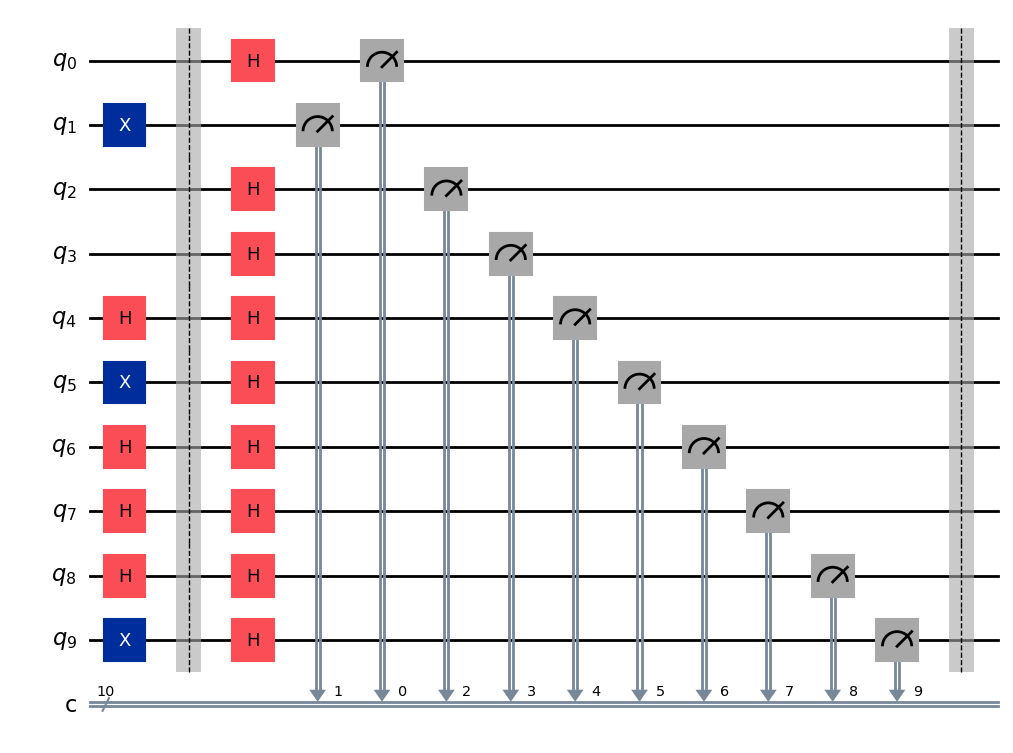


=== Starting BB84 run (mode: intercept) – 100 shots of 10 qubits ===
--- Shot 1/100 ---
Alice bits   : 1111001010
Alice bases  : XXZZXXZZXZ
Eve bases    : ZXZZXZZXZZ
Eve raw      : 1111011000
Bob bases    : XXXXZZZZZZ
Bob raw      : 1101111100
Sift indices : [0, 1, 6, 7, 9]
Sifted A/B   : 11100 11110 

Sift indices : [0, 1, 6, 7, 9]
Sifted bases : XXZZZ XXZZZ (Eve: ZXZXZ)
>>> Raw circuit (depth 4 ):


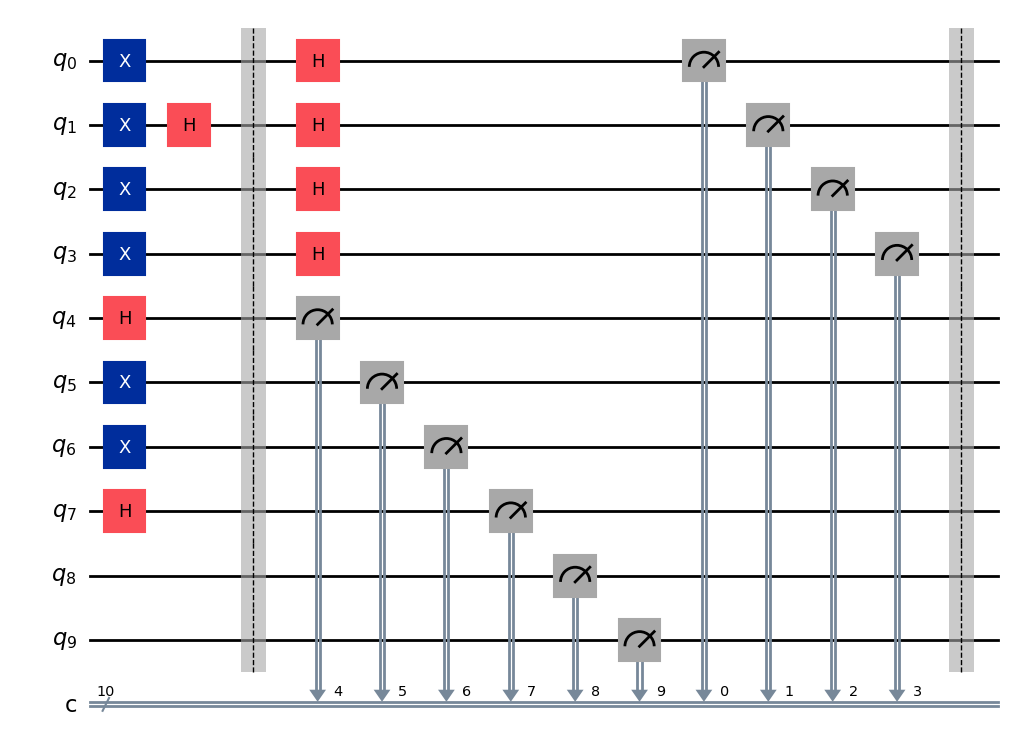

In [28]:
def run_bb84(shot_count: int, key_len: int, eve_mode: str):
    
    sift_a, sift_b = [], []
    sift_bases_a, sift_bases_b = [], []
    sift_bases_e = []  
    
    
    print(f"\n=== Starting BB84 run (mode: {eve_mode}) – {shot_count} shots of {key_len} qubits ===")

    for shot in range(shot_count):

        # Generate random bits and bases for alice and bob
        bits_a = random_bits(key_len)
        bases_a = random_bits(key_len)
        bases_b = random_bits(key_len)

        # Build the circuit to run without any interception or with interception by Eve
        if eve_mode == "none":
            sender = build_sender(bits_a, bases_a)
            receiver = build_receiver(bases_b)
            full_qc = sender.compose(receiver)

        elif eve_mode == "intercept":
            # intercept–resend
            bases_e = random_bits(key_len)
            sender_ae = build_sender(bits_a, bases_a)
            eve_recv = build_receiver(bases_e)

            # Alice→Eve
            qc_ae = sender_ae.compose(eve_recv)
            raw_ae = run_circuit(qc_ae, backend, noise)

            # Eve→Bob
            eve_sender = build_sender(list(map(int, raw_ae)), bases_e)
            receiver = build_receiver(bases_b)
            full_qc = eve_sender.compose(receiver)

        # Execute & sift
        raw_b = run_circuit(full_qc, backend, noise)

        sa, sb, ba_s, bb_s, idx = sift(bits_a, raw_b, bases_a, bases_b)
        
        sift_a.extend(sa)
        sift_b.extend(sb)

        sift_bases_a.extend(ba_s)
        sift_bases_b.extend(bb_s)

        if eve_mode == "intercept":
            sift_bases_e.extend([bases_e[i] for i in idx])


        # Logging for the first shot to showcase bits and bases
        if (shot < 1):
            print(f"--- Shot {shot + 1}/{shot_count} ---")
            print("Alice bits   :", pretty(bits_a))
            print("Alice bases  :", bases_to_str(bases_a))
            if eve_mode == "intercept":
                print("Eve bases    :", bases_to_str(bases_e))
                print("Eve raw      :", raw_ae)
            print("Bob bases    :", bases_to_str(bases_b))
            print("Bob raw      :", raw_b)
            print("Sift indices :", idx)
            print("Sifted A/B   :", pretty(sa), pretty(sb), "\n")
            print("Sift indices :", idx)
            print("Sifted bases :", bases_to_str(ba_s), bases_to_str(bb_s),
                  ("(Eve: "+bases_to_str(sift_bases_e[:len(ba_s)])+")") if eve_mode=="intercept" else "")


        # Display circuit diagrams for the very first shot
        if shot == 0:
            print(">>> Raw circuit (depth", full_qc.depth(), "):")
            display(full_qc.draw("mpl"))


    return sift_a, sift_b, sift_bases_a, sift_bases_b, sift_bases_e

sift_a_honest, sift_b_honest, ba_honest, bb_honest, _ = run_bb84(SHOTS, KEY_LEN, "none")
sift_a_eve,    sift_b_eve,    ba_eve,    bb_eve,    be_eve = run_bb84(SHOTS, KEY_LEN, "intercept")


In [29]:
def correction( sift_a: List[int], sift_b: List[int], bases_a_s: List[int], bases_b_s: List[int], label: str, bases_e_s: Optional[List[int]] = None, ) -> None:
    
    # 1) Estimate QBER on the sifted bits
    q_est = qber(sift_a, sift_b)

    # 3) Cascade reconciliation
    k0         = required_initial_block_size(q_est)
    b_corr, leak = cascade_correct(sift_a, sift_b, k0, CASCADE_PASSES)

    # 4) Privacy amplification
    key_a_pre = sift_a
    key_b_pre = b_corr
    key_a, seed = pa(key_a_pre)
    key_b, _    = pa(key_b_pre, seed=seed)

    # 6) Print full summary
    print(f"\n --------------- {label} ----------------------------------------")

       # 2) Immediate Eve detection on raw sifted bits (only for intercept mode)
    raw_mismatches = sum(a != b for a, b in zip(sift_a, sift_b))
    # if label == "Intercept-Resend Eve":
    #     if raw_mismatches > 0:
    #         print(f"Eve detected before reconciliation: {raw_mismatches} mismatches in raw sifted key.")
    #     else:
    #         print("Unexpected: no mismatches despite intercept–resend mode.")
    print(f"Total bits Sent            : {KEY_LEN*SHOTS}")
    print(f"Sifted bits                : {len(sift_a)}")
    print("Sifted bases Alice         :", bases_to_str(bases_a_s))
    print("Sifted bases Bob           :", bases_to_str(bases_b_s))
    if bases_e_s is not None:
        print("Sifted bases Eve           :", bases_to_str(bases_e_s))
    print(f"Measured QBER              : {q_est:.2%}")
    # print(f"Cascade parity bits leaked : {leak}")
    print(f"Keys match BEFORE PA       : {key_a_pre == key_b_pre}")
    print(f"Keys match AFTER PA        : {key_a == key_b}")
    print(f"Final Keys Alice           : {pretty(key_a)}")
    print(f"Final Keys Bob             : {pretty(key_b)}")
    # we leave ℓ off here, see next cell for abort logic

# === Run analysis ===
correction(sift_a_honest, sift_b_honest, ba_honest, bb_honest, "Honest Channel")
correction(sift_a_eve,    sift_b_eve,    ba_eve,     bb_eve,     "Intercept-Resend Eve", be_eve)



 --------------- Honest Channel ----------------------------------------
Total bits Sent            : 1000
Sifted bits                : 515
Sifted bases Alice         : ZXXXXZXXXZXZXZXXXXXXXZXZZZZZZXXZZZZZXXZXXXXXZZZXZXZZXXZXXZZXZXZXZXXXZXZZXZXXXZXZXXXZZXZZXZZXZXZXXXXXZXXXZXZZXZXZZZXXXXXZXXXXZZZXZXZZXXZXZZZZXZZZZZXXZZZZXXZZXZXZXXXXXXZZZXZXZXZZZZZZZZZXZXXXXZXZXXZXXXXXZZZXXZZXZXXXXZZZXZXZXXXXZZXXXXXZZZXXZXZZZZXXXZZZZZZZZZZZXZZXXZZXXXXZXZXZZXZZZZZZXZXZZZXXZZXZXXZZXXZXZZXZZZXXXZZZXXZXZXZZXXZXXZXZXZXXZZXZZZZXZZZZZZXXXZXZXZXXZZXXZXZXZZXZXZXZZXZZXZZXZZXZZXZZXXZXXZZZXXZXZXXZXZXXZXXZXZZZZZXXZZZZXZXXXZXZXZXXXXZXZXZXXXZZZZXXXXXXXZZXZZXXXXXZXXZZXZZXZXXXZXZZXZZXZXZXXXXZXZXZZXZXXXZZZZZXXZX
Sifted bases Bob           : ZXXXXZXXXZXZXZXXXXXXXZXZZZZZZXXZZZZZXXZXXXXXZZZXZXZZXXZXXZZXZXZXZXXXZXZZXZXXXZXZXXXZZXZZXZZXZXZXXXXXZXXXZXZZXZXZZZXXXXXZXXXXZZZXZXZZXXZXZZZZXZZZZZXXZZZZXXZZXZXZXXXXXXZZZXZXZXZZZZZZZZZXZXXXXZXZXXZXXXXXZZZXXZZXZXXXXZZZXZXZXXXXZZXXXXXZZZXXZXZZZZXXXZZZZZZZZZZZXZZXXZZXXXXZXZXZZXZZZZZZXZXZZ